In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os

## **Dataset Generation**

In [2]:
def generate_dataset(dataset=1, num_samples=40):
    if dataset == 1:
        np.random.seed(45)
        x = np.random.uniform(-20, 20, num_samples)
        f_x = 100*x + 1
        eps = np.random.randn(num_samples)
        y = f_x + eps
        theta_star = torch.tensor([1.0, 100.0])
    else:
        np.random.seed(45)
        x = np.random.uniform(-1, 1, num_samples)
        f_x = 3*x + 4
        eps = np.random.randn(num_samples)
        y = f_x + eps
        theta_star = torch.tensor([4.0, 3.0])

    # Convert to torch tensors
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    X = torch.stack([torch.ones_like(x), x], dim=1) 
    return X, y, theta_star

In [3]:
def mse_loss(X,y, theta):
    pred = X @ theta
    return 0.5 * torch.mean((y-pred)**2)

In [4]:
def comp_grad(X, y, theta):
    n = X.shape[0]
    grad = -(X.T @ (y- X @ theta))/n
    return grad

In [5]:
def fullgd(X, y, theta_star, lr=0.0001, eps=0.001, max_epoch=1000):
    theta = torch.zeros(X.shape[1])
    losses, path = [],[]
    steps = 0

    for epoch in range(max_epoch):
        loss = mse_loss(X,y,theta)
        losses.append(loss.item())
        path.append(theta.clone().numpy())

        grad = comp_grad(X,y,theta)
        theta -= lr*grad

        steps += 1

        if torch.norm(theta - theta_star) < eps:
            break
    
    return theta, losses, np.array(path), steps

## **Normal Descent**

In [6]:
def sgd(X, y, theta_star, lr=0.0001, eps=0.001, max_epoch=1000):
    theta = torch.zeros(X.shape[1])
    losses, path = [],[]
    steps = 0
    n = X.shape[0]

    for epoch in range(max_epoch):
        idx = torch.randperm(n)

        for i in idx:
            xi = X[i].unsqueeze(0)
            yi = y[i].unsqueeze(0)

            grad = comp_grad(xi, yi, theta)
            theta -= lr * grad

            path.append(theta.clone().numpy())
            steps += 1
            if torch.norm(theta - theta_star) < eps:
                losses.append(mse_loss(X, y, theta).item())
                return theta, losses, np.array(path), steps

        losses.append(mse_loss(X, y, theta).item())
    return theta, losses, np.array(path), steps

In [7]:
def run_experiments(num_trials=5):
    results = {}
    for dataset in [1, 2]:
        X, y, theta_star = generate_dataset(dataset)

        theta_gd, losses_gd, path_gd, steps_gd = fullgd(X, y, theta_star, lr=0.01)

        steps_sgd_list, paths_sgd, losses_sgd = [], [], []
        for trial in range(num_trials):
            torch.manual_seed(45 + trial)
            theta_sgd, losses_trial, path_trial, steps_trial = sgd(X, y, theta_star, lr=0.01)
            steps_sgd_list.append(steps_trial)
            paths_sgd.append(path_trial)
            losses_sgd.append(losses_trial)

        results[dataset] = {
            "theta_star": theta_star,
            "gd": (theta_gd, losses_gd, path_gd, steps_gd),
            "sgd": (theta_sgd, losses_sgd, paths_sgd, np.mean(steps_sgd_list))
        }
    return results

results = run_experiments()


Dataset 1
 Full-batch GD steps: 1000, final θ: [ 0.95056736 99.98412   ]
 SGD average steps: 27332.40, final θ (last trial): [  1.0005115 100.00057  ]


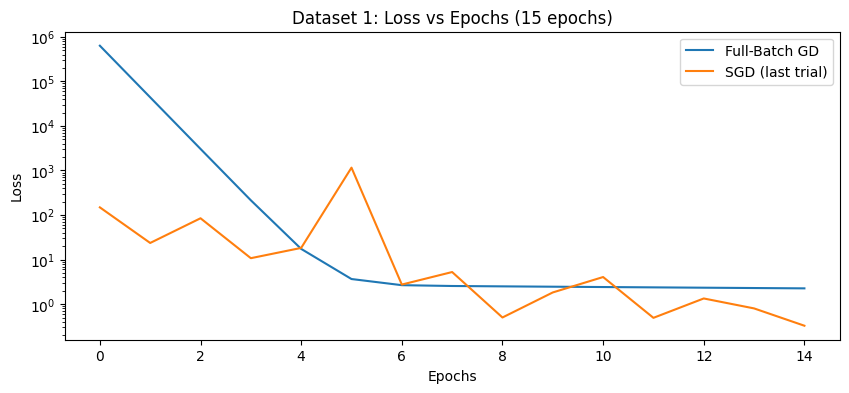

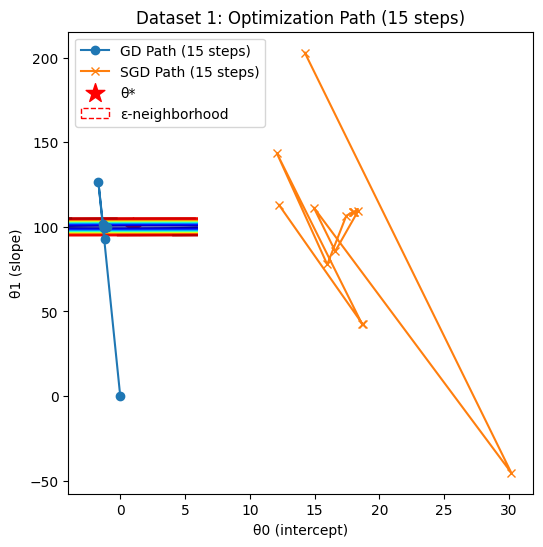


Dataset 2
 Full-batch GD steps: 1000, final θ: [3.9327366 2.5362704]
 SGD average steps: 40000.00, final θ (last trial): [3.9547558 2.677976 ]


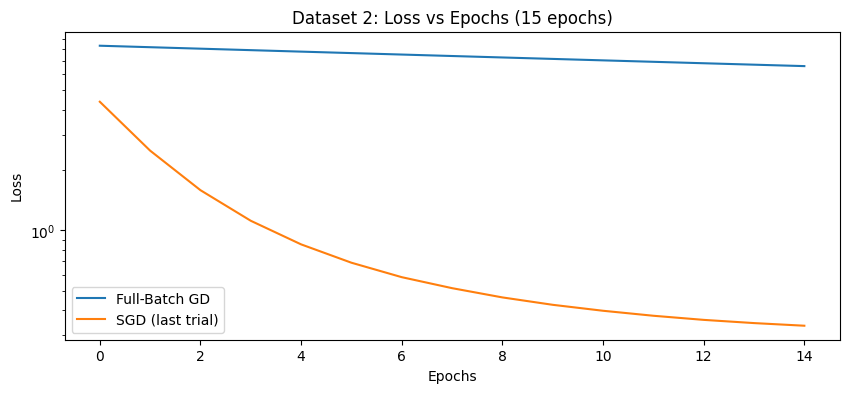

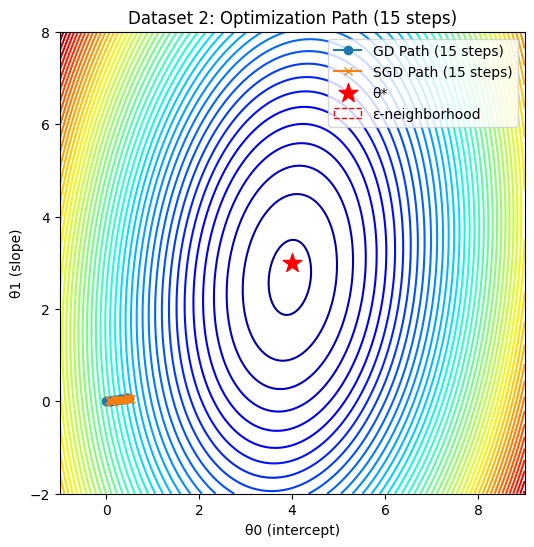

In [15]:
for dataset in [1, 2]:
    X, y, theta_star = generate_dataset(dataset)

    theta_gd, losses_gd, path_gd, steps_gd = results[dataset]["gd"]
    theta_sgd, losses_sgd, paths_sgd, steps_sgd_avg = results[dataset]["sgd"]

    print(f"\nDataset {dataset}")
    print(f" Full-batch GD steps: {steps_gd}, final θ: {theta_gd.numpy()}")
    print(f" SGD average steps: {steps_sgd_avg:.2f}, final θ (last trial): {theta_sgd.numpy()}")

    plt.figure(figsize=(10,4))
    plt.plot(losses_gd[:15], label="Full-Batch GD")
    plt.plot(losses_sgd[-1][:15], label="SGD (last trial)")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Dataset {dataset}: Loss vs Epochs (15 epochs)")
    plt.legend()
    plt.show()

    t0 = np.linspace(theta_star[0].item()-5, theta_star[0].item()+5, 200)
    t1 = np.linspace(theta_star[1].item()-5, theta_star[1].item()+5, 200)
    T0, T1 = np.meshgrid(t0, t1)
    Z = np.zeros_like(T0)

    for i in range(T0.shape[0]):
        for j in range(T0.shape[1]):
            theta_temp = torch.tensor([T0[i,j], T1[i,j]], dtype=torch.float32)
            Z[i,j] = mse_loss(X, y, theta_temp).item()

    plt.figure(figsize=(6,6))
    plt.contour(T0, T1, Z, levels=50, cmap="jet")

    plt.plot(path_gd[:15,0], path_gd[:15,1], "o-", label="GD Path (15 steps)")
    plt.plot(paths_sgd[-1][:15,0], paths_sgd[-1][:15,1], "x-", label="SGD Path (15 steps)")

    plt.scatter(theta_star[0], theta_star[1], c="red", marker="*", s=200, label="θ*")
    circle = plt.Circle((theta_star[0], theta_star[1]), 0.001, color="red", fill=False, linestyle="--", label="ε-neighborhood")
    plt.gca().add_artist(circle)

    plt.xlabel("θ0 (intercept)")
    plt.ylabel("θ1 (slope)")
    plt.title(f"Dataset {dataset}: Optimization Path (15 steps)")
    plt.legend()
    plt.show()


#### We observe that SGD converges faster than Full batch GD, although Full batch GD convergence is much more stable

## **Using Momentum**

In [16]:
def fullgd_momentum(X, y, theta_star, lr=0.0001, beta=0.9, eps=0.001, max_epoch=2000):
    theta = torch.zeros(X.shape[1])
    velocity = torch.zeros(X.shape[1])
    losses, path = [],[]
    steps = 0

    for epoch in range(max_epoch):
        loss = mse_loss(X,y,theta)
        losses.append(loss.item())
        path.append(theta.clone().numpy())

        grad = comp_grad(X,y,theta)
        velocity = beta * velocity + lr * grad
        theta -= velocity

        steps += 1

        if torch.norm(theta - theta_star) < eps:
            break
            
    return theta, losses, np.array(path), steps

In [10]:
def sgd_momentum(X, y, theta_star, lr=0.0001, beta=0.9, eps=0.001, max_epoch=1000):
    theta = torch.zeros(X.shape[1])
    velocity = torch.zeros(X.shape[1])
    losses, path = [],[]
    steps = 0
    n = X.shape[0]

    for epoch in range(max_epoch):
        epoch_loss = mse_loss(X, y, theta).item()
        losses.append(epoch_loss)

        idx = torch.randperm(n)

        for i in idx:
            xi = X[i].unsqueeze(0)
            yi = y[i].unsqueeze(0)
            
            path.append(theta.clone().numpy())
            grad = comp_grad(xi, yi, theta)
            velocity = beta * velocity + lr * grad
            theta -= velocity

            steps += 1
            if torch.norm(theta - theta_star) < eps:
                return theta, losses, np.array(path), steps
            if steps >= max_epoch * n:
                 return theta, losses, np.array(path), steps

    return theta, losses, np.array(path), steps

In [17]:
def visualize_momentum_vectors(X, y, theta_star, lr, beta, n_steps=15):
    theta = torch.zeros(X.shape[1])
    velocity = torch.zeros(X.shape[1])
    
    path = [theta.clone().numpy()]
    vectors = []

    for i in range(n_steps):
        grad = comp_grad(X, y, theta)
        
        new_velocity = beta * velocity + lr * grad
        
        vectors.append({
            'position': theta.clone().numpy(),
            'gradient': -lr * grad.clone().numpy(), # Plot scaled negative gradient
            'update': -new_velocity.clone().numpy() # Plot total update vector (theta_new - theta_old)
        })
        
        theta -= new_velocity
        path.append(theta.clone().numpy())
        velocity = new_velocity

    # Plotting logic
    plt.figure(figsize=(8,8))
    t0 = np.linspace(theta_star[0].item()-5, theta_star[0].item()+5, 200)
    t1 = np.linspace(theta_star[1].item()-5, theta_star[1].item()+5, 200)
    T0, T1 = np.meshgrid(t0, t1)
    Z = np.array([[mse_loss(X, y, torch.tensor([t0_val, t1_val], dtype=torch.float32)).item() for t0_val in t0] for t1_val in t1])
    
    plt.contour(T0, T1, Z, levels=np.logspace(0, 5, 35), cmap='jet')
    
    path_arr = np.array(path)
    plt.plot(path_arr[:, 0], path_arr[:, 1], 'w--', label='Optimization Path', alpha=0.7)

    for i, v in enumerate(vectors):
        pos = v['position']
        grad_vec = v['gradient']
        update_vec = v['update']
        
        plt.quiver(pos[0], pos[1], grad_vec[0], grad_vec[1], angles='xy', scale_units='xy', scale=1, color='red', width=0.005, label='Gradient Component' if i == 0 else "")
        plt.quiver(pos[0], pos[1], update_vec[0], update_vec[1], angles='xy', scale_units='xy', scale=1, color='cyan', width=0.005, label='Momentum Update Vector' if i == 0 else "")

    plt.xlabel('θ0')
    plt.ylabel('θ1')
    plt.title(f'Momentum Vector Visualization (First {n_steps} Steps)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


==================== DATASET 1 ====================

--- Average Steps to Converge ---
Full-batch GD: 1000
SGD: 40000
Full-batch GD with Momentum: 20000
SGD with Momentum: 11193


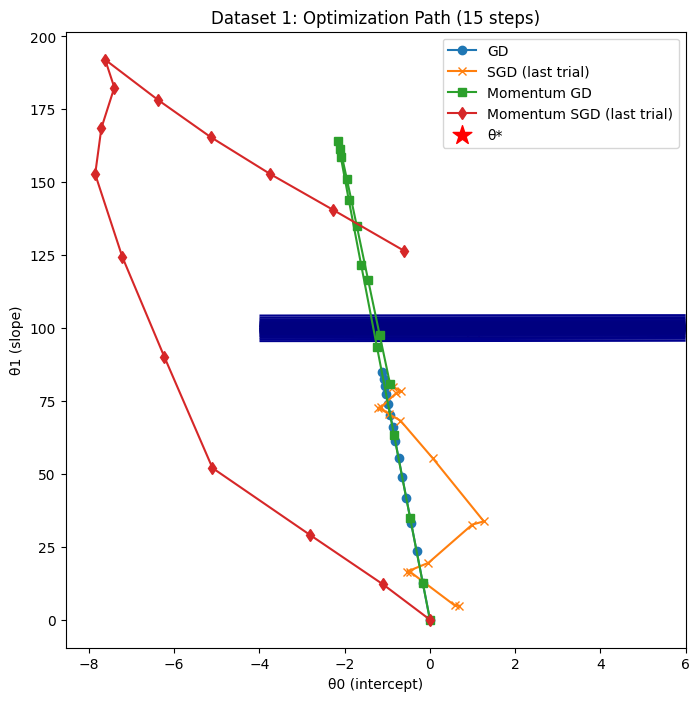

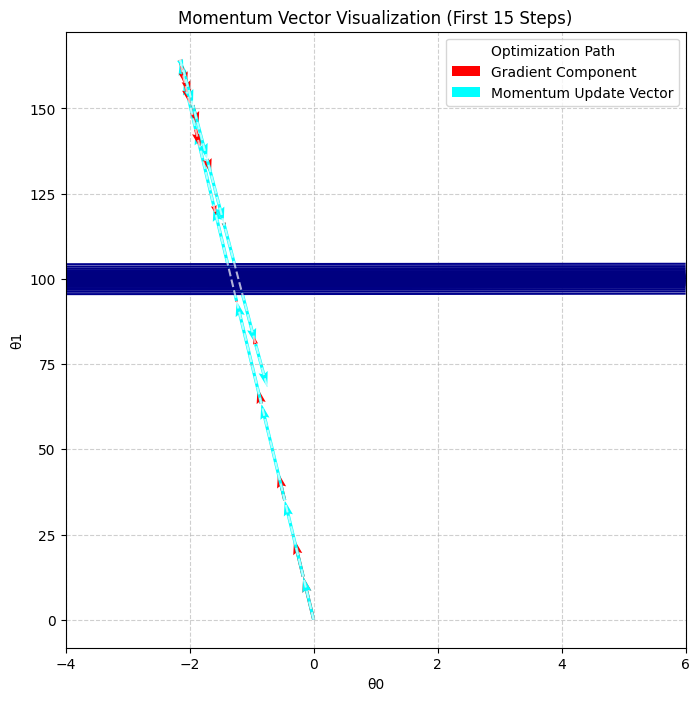


==================== DATASET 2 ====================

--- Average Steps to Converge ---
Full-batch GD: 1000
SGD: 40000
Full-batch GD with Momentum: 20000
SGD with Momentum: 40000


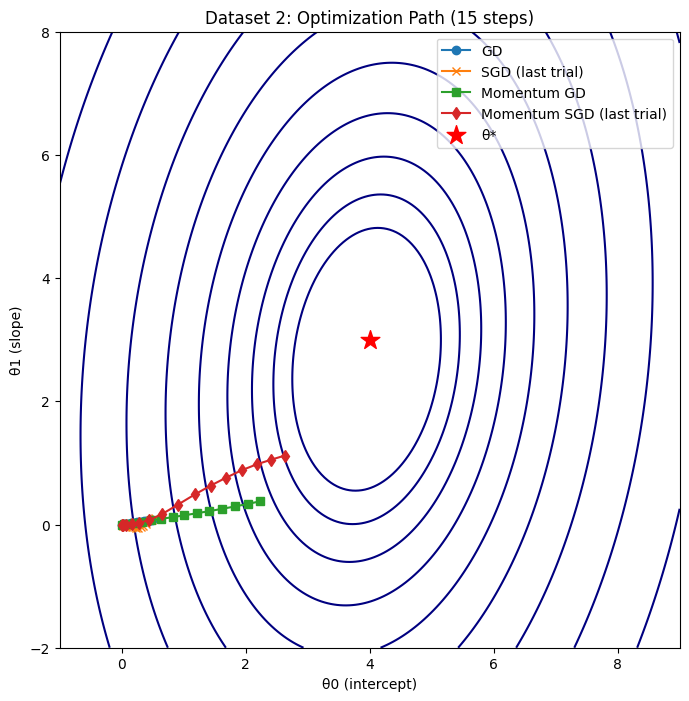

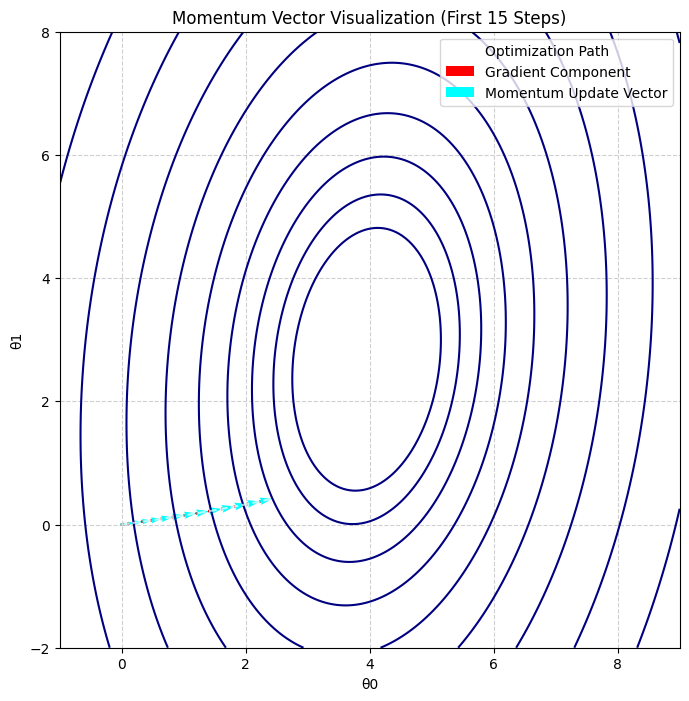

In [14]:
num_trials = 5
eps = 0.001
beta = 0.9

for dataset_id in [1, 2]:
    print(f"\n{'='*20} DATASET {dataset_id} {'='*20}")
    X, y, theta_star = generate_dataset(dataset=dataset_id)
    
    lr_gd = 0.001 if dataset_id == 1 else 0.01
    lr_sgd = 0.001 if dataset_id == 1 else 0.01

    theta_gd, losses_gd, path_gd, steps_gd = fullgd(X, y, theta_star, lr=lr_gd, eps=eps)
    theta_mom, losses_mom, path_mom, steps_mom = fullgd_momentum(X, y, theta_star, lr=lr_gd, beta=beta, eps=eps)

    steps_sgd_list, steps_sgdm_list = [], []
    for trial in range(num_trials):
        _, _, path_sgd_trial, steps_sgd_trial = sgd(X, y, theta_star, lr=lr_sgd, eps=eps)
        _, _, path_sgdm_trial, steps_sgdm_trial = sgd_momentum(X, y, theta_star, lr=lr_sgd, beta=beta, eps=eps)
        steps_sgd_list.append(steps_sgd_trial)
        steps_sgdm_list.append(steps_sgdm_trial)
    
    avg_steps_sgd = np.mean(steps_sgd_list)
    avg_steps_sgdm = np.mean(steps_sgdm_list)

    print("\n--- Average Steps to Converge ---")
    print(f"Full-batch GD: {steps_gd}")
    print(f"SGD: {avg_steps_sgd:.0f}")
    print(f"Full-batch GD with Momentum: {steps_mom}")
    print(f"SGD with Momentum: {avg_steps_sgdm:.0f}")
    
    # --- Visualization of Convergence Path (15 steps) ---
    t0 = np.linspace(theta_star[0].item()-5, theta_star[0].item()+5, 200)
    t1 = np.linspace(theta_star[1].item()-5, theta_star[1].item()+5, 200)
    T0, T1 = np.meshgrid(t0, t1)
    Z = np.zeros_like(T0)
    for i in range(T0.shape[0]):
        for j in range(T0.shape[1]):
            theta_temp = torch.tensor([T0[i,j], T1[i,j]], dtype=torch.float32)
            Z[i,j] = mse_loss(X, y, theta_temp).item()

    plt.figure(figsize=(8,8))
    plt.contour(T0, T1, Z, levels=np.logspace(0, 5, 35), cmap="jet")
    plt.plot(path_gd[:15,0], path_gd[:15,1], "o-", label="GD")
    plt.plot(path_sgd_trial[:15,0], path_sgd_trial[:15,1], "x-", label="SGD (last trial)")
    plt.plot(path_mom[:15,0], path_mom[:15,1], "s-", label="Momentum GD")
    plt.plot(path_sgdm_trial[:15,0], path_sgdm_trial[:15,1], "d-", label="Momentum SGD (last trial)")
    plt.scatter(theta_star[0], theta_star[1], c="red", marker="*", s=200, label="θ*")
    plt.xlabel("θ0 (intercept)")
    plt.ylabel("θ1 (slope)")
    plt.title(f"Dataset {dataset_id}: Optimization Path (15 steps)")
    plt.legend()
    plt.show()

    
    visualize_momentum_vectors(X, y, theta_star, lr=lr_gd, beta=beta)

#### Momentum accelerates convergence but can cause instability.

#### SGD introduces randomness (noisy but faster updates).

#### Standard GD is the most stable but slowest to converge.